* Jupyter notebook of examples can be found in Binder: http://mybinder.org/repo/bastula/dicom-notebooks
* Code on https://github.com/dicompyler/dicompyler-core

* ipywidgets https://ipywidgets.readthedocs.io/en/latest/

##### RT Dose Methods
* dicomparser.py https://github.com/dicompyler/dicompyler-core/blob/master/dicompylercore/dicomparser.py

* GetStructures() = Returns a dictionary of structures (ROIs)
* GetDVHs()  = Returns cumulative dose-volume histograms (DVHs)
* GetDoseGrid = Return the 2d dose grid for the given slice position (mm)

##### DVH properties
* dvh.py https://github.com/dicompyler/dicompyler-core/blob/master/dicompylercore/dvh.py

* absolute_dose() = Return an absolute dose DVH
* relative_dose() = Return a relative dose DVH based on a prescription dose, rx_dose
* absolute_volume() = Return an absolute volume DVH.
* describe() =  a summary of DVH statistics in a text based format. Only shows volume statistics if a rx_dose has been defined
* compare() = Compare the DVH properties with another DVH
* volume_constraint() = Calculate the volume that receives at least a specific dose, i.e. V100, V150 or V20Gy
* dose_constraint() = Calculate the maximum dose that a specific volume receives, .i.e. D90, D100 or D2cc
* statistic() = Return a DVH dose or volume statistic, in the form of D90, D100, D2cc, V100 or V20Gy, etc.
* class DVHValue(object): Class that stores DVH values with the appropriate units
* relative_volume() = Return a relative volume DVH
* absolute_volume() = Return a absolute volume DVH

##### Calculate dose volume histogram (DVH) from DICOM RT Structure/Dose data
* dvhcalc.py https://github.com/dicompyler/dicompyler-core/blob/master/dicompylercore/dvhcalc.py

* get_dvh() = Calculate a cumulative DVH in Gy from a DICOM RT Structure Set & Dose
* calculate_dvh() = Calculate the differential DVH for the given structure and dose grid
* calculate_plane_histogram() = Calculate the DVH for the given plane in the structure
* get_contour_mask() = Get the mask for the contour with respect to the dose plane
* calculate_contour_dvh() = Calculate the differential DVH for the given contour and dose plane

In [1]:
%matplotlib inline
import os
import numpy as np
import dicom as dicom
from dicompylercore import dicomparser, dvh, dvhcalc
import matplotlib.pyplot as plt
import urllib.request
import os.path
from ipywidgets import FloatSlider, interactive, interact
from scipy.misc import imresize
from scipy import interpolate
from gamma3d import gamma3d
from pylinac.core.image import ArrayImage
import copy
import scipy.ndimage.filters as spf


path = os.getcwd()
print(path)
os.listdir(path)

400.000008941
3.20000007153
C:\Users\RCole02.ROYALSURREY\Desktop\GitHub\Useful-python-for-medical-physics\Experiments in ipython notebooks\dicompyler-core experiments\AXB project\Lung plan 30 exported 11-10-2016


['.ipynb_checkpoints',
 'archive',
 'Case_30 Lung PTV 31-10-2016.ipynb',
 'Case_30_AAA_Doses.dcm',
 'Case_30_AAA_Structures.dcm',
 'Case_30_Dm_Doses.dcm',
 'diff_slice.csv',
 'diff_slice.png',
 'gamma3d.py',
 'gamma_display.csv',
 'Omnipro slice 2.5mm',
 '__pycache__']

My fork of dicompylercore is in C:\Users\...\Desktop\GitHub\dicompyler-core my fork\dicompyler-core

In [2]:
#AAA.GetDoseData().keys()

In [3]:
def f_info(file_):    # pass a dicomparser object, e.g. AAA
    print('****')
    print('position = ' + str( file_.GetDoseData()['position']  ))
    print('dosegridscaling = ' + str( file_.GetDoseData()['dosegridscaling']  ))
    print('frames = ' + str( file_.GetDoseData()['frames']  ))   
    print('rows = ' + str( file_.GetDoseData()['rows']  ))
    print('columns = ' + str( file_.GetDoseData()['columns']  ))
    print('pixelspacing = ' + str( file_.GetDoseData()['pixelspacing']  ))
    #print('GridFrameOffsetVector = ' + str( file_.ds.GridFrameOffsetVector ))   
    print('dosemax (pix) = ' + str( file_.GetDoseData()['dosemax']  ))
    print('dosemax (Gy) = ' + str( file_.GetDoseData()['dosemax'] * file_.GetDoseData()['dosegridscaling'] ))
    #print('samplesperpixel = ' + str( file_.GetDoseData()['samplesperpixel']  ))

In [4]:
def get_dose_array(rtdose):   # e.g. rtdose = AAA dicomparser object, return 3d numpy array of dose data
    x = rtdose.GetDoseData()['rows'] 
    y = rtdose.GetDoseData()['columns'] 
    z = rtdose.GetDoseData()['frames']
    rtdose_array = np.zeros((x, y, z))  # create 3d array for data
    planes = (np.array(rtdose.ds.GridFrameOffsetVector) * rtdose.ds.ImageOrientationPatient[0]) + rtdose.ds.ImagePositionPatient[2]    
    for i, plane in enumerate(planes):  # put dose data in 3d array
        rtdose_array[:, :, i] = rtdose.GetDoseGrid(plane)
    rtdose_array = rtdose_array* rtdose.GetDoseData()['dosegridscaling']   # convert from pixel to Gy
    return(rtdose_array)

# plt.imshow(get_dose_array(AAA)[:,:, 50]);   # exampleusage

# Lung PTV for case 30

In [25]:
files = ['Case_30_AAA_Structures.dcm',  'Case_30_AAA_Doses.dcm', 'Case_30_Dm_Doses.dcm']

In [26]:
Structures_set = dicomparser.DicomParser(files[0])
AAA = dicomparser.DicomParser(files[1])    # a dicomparser object
Dm = dicomparser.DicomParser(files[2])

Get the dose data, returned in a dict

In [27]:
f_info(AAA)
f_info(Dm)

****
position = ['-189.238409', '-139.7377839', '-202.5']
dosegridscaling = 5.5e-5
frames = 128
rows = 100
columns = 152
pixelspacing = ['2.5', '2.5']
dosemax (pix) = 1346133.0
dosemax (Gy) = 74.037315
****
position = ['-190.488409', '-140.9877839', '-202.5']
dosegridscaling = 5.0691244e-5
frames = 128
rows = 101
columns = 153
pixelspacing = ['2.5', '2.5']
dosemax (pix) = 1472137.0
dosemax (Gy) = 74.624455868428


In [28]:
(5.5e-5)*1346133.0

74.037315

## Get Dose data and plot difference

Use helper function get_dose_array()

In [29]:
AAA_dose = get_dose_array(AAA)
print(AAA_dose.shape)
x = AAA_dose.shape[0]
y = AAA_dose.shape[1]
print('***')

Dm_dose = get_dose_array(Dm)
print(Dm_dose.shape)
Dm_dose = Dm_dose[:x,:y, :]  # put on same grid
print(Dm_dose.shape)

(100, 152, 128)
***
(101, 153, 128)
(100, 152, 128)


In [30]:
gamma_map = gamma3d(ArrayImage(AAA_dose, dpi=1), ArrayImage(Dm_dose, dpi=1),  threshold=0.0, doseTA=1, distTA=1, )  # doseTA=0.01, distTA=0.01, 

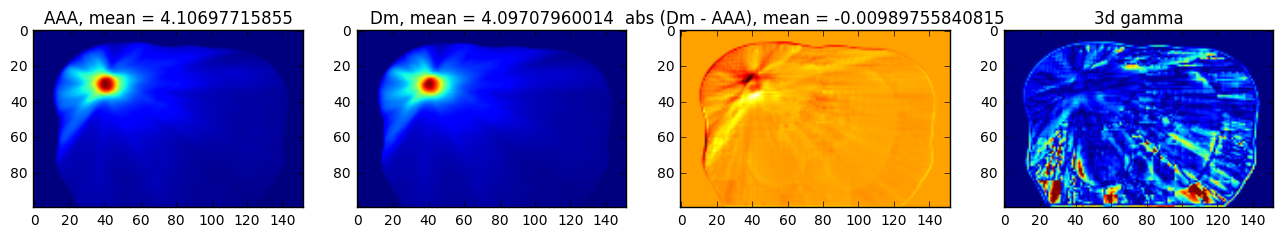

In [32]:
y = FloatSlider(
    value=75,
    min=0,
    max=128,
    step=1,
    description='Slice Position in numpy:',
)

def showdoseboth(z):
    
    AAA_display = AAA_dose[:,:,z]
    Dm_display  = Dm_dose[:,:,z]
    gamma_display = gamma_map[:,:,z]
    
   # cmax = max(AAA_display.max(), Dm_display.max())  # use identical colour scale for ax1 & ax2
        
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 8))

    ax1.imshow(AAA_display)  # , vmin=0, vmax=cmax
    ax1.set_title('AAA, mean = ' + str(np.mean(AAA_display)))
    
    ax2.imshow(Dm_display)     # , vmin=0,vmax=cmax
    ax2.set_title('Dm, mean = ' + str(np.mean(Dm_display)))   
    
    # Difference analysis
    difference_display = np.subtract(Dm_display, AAA_display)
    ax3.imshow(difference_display, cmap='hot') #  vmin=0,vmax=50,    
    ax3.set_title('abs (Dm - AAA), mean = ' + str(np.mean(difference_display)))
    
    #### Gamma analysis
    ax4.imshow(gamma_display , vmin=0,vmax=2.0)  # , cmap='hot'
    ax4.set_title('3d gamma' )

    plt.show()
    

interactive(showdoseboth, z=75)

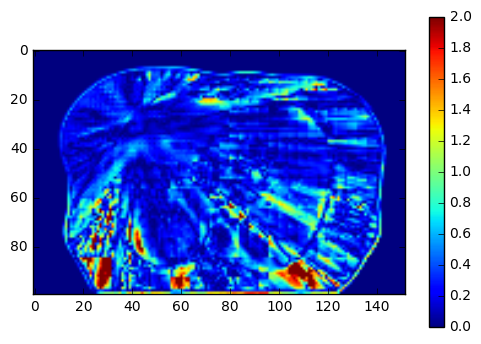

In [33]:
z = 75
gamma_display = gamma_map[:,:,z]
plt.imshow(gamma_display, vmin=0,vmax=2.0)
plt.colorbar()
#np.savetxt('gamma_display.csv', gamma_display, delimiter=',')

In [13]:
z = 50
AAA_display = AAA_dose[:,:, z]
print(np.mean(AAA_display))

print(np.mean(Dm_dose[:,:, z]))
Dm_display =  imresize(Dm_dose[:,:, z], AAA_display.shape)  # make image grids identical , somehow is changing data
print(np.mean(Dm_display))

Dm_display2 =  np.resize(Dm_dose[:,:, z], AAA_display.shape)  # make image grids identical , somehow is changing data
print(np.mean(Dm_display2))

nan
0.207989412369
48.7106578947
0.207989412369


# DVH analysis

Print the structures. Will want to parse these into allowed structure names later

In [14]:
range(5)

range(0, 5)

In [15]:
key = 5   #  Keys start from 1
structures = Structures_set.GetStructures()  # returns a dict of structures
structures[key]

{'color': array([255,   0,   0]),
 'empty': False,
 'id': 5,
 'name': 'PTV CHEST_P27',
 'type': 'PTV'}

In [16]:
for i, structure in enumerate(structures):
    print(str(i+1) +  '   ' + structures[structure]['name'])

1   BODY_P27
2   Both Lungs_P9
3   ITV_P19
4   Heart_P
5   PTV CHEST_P27
6   Foramen_P
7   Oesophagus_P27
8   Foramen+3mm_P26
9   Skin-PTV+2cm_P13
10   Inner Ring_P3
11   Ribs-PTV_P6
12   Pseudo ITV_P10
13   R Brachial ple18
14   Ribs_P16
15   PseudoPTV-ITV_19
16   Skin_P19
17   Both Lungs-ITV20
18   Bronchial tree19
19   Rt_Lung_P19
20   PTV ring 2-3cm19
21   Lt_Lung_P18
22   Airway avoidan19
23   Trachea_P19
24   L Brachial ple19
25   CouchSurface_P24
26   CouchInterior_24
27   Dose 100[%]_P15
28   Dose 50[%]_P16
29   Dose 55[Gy]_P
30   Dose 27.5[Gy]_P


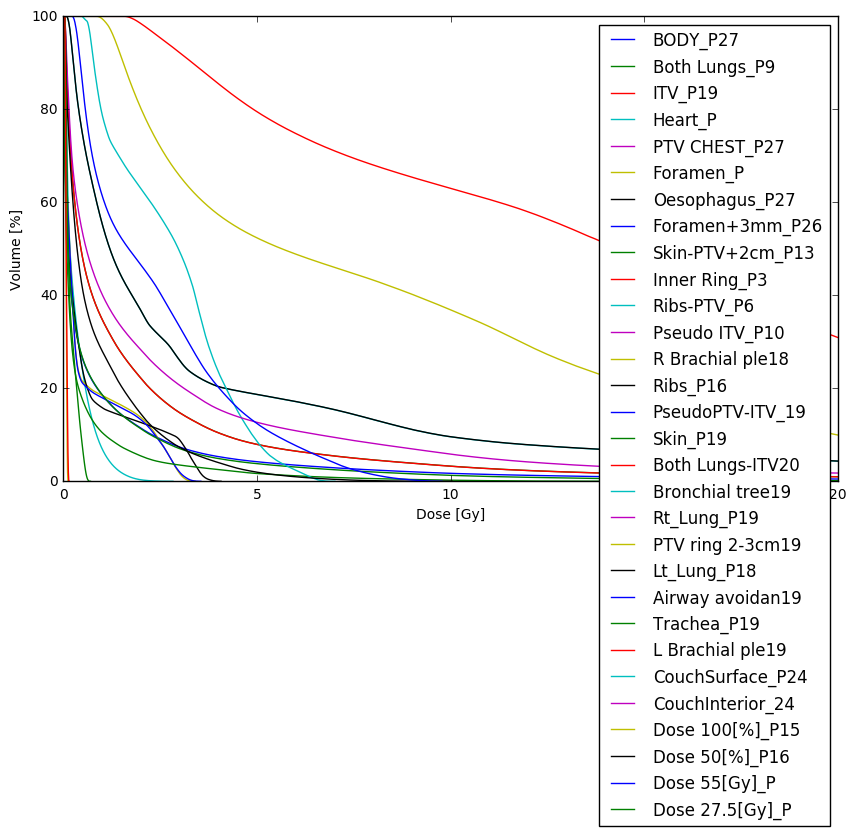

In [18]:
plt.figure(figsize=(10, 6))
plt.axis([0, 20, 0, 100])
for s in structures.values():
    if not s['empty']:
        dvh.DVH.from_dicom_dvh(AAA.ds, s['id'], name=s['name']).relative_volume.plot()

In [17]:
key = 5
PTV = AAA.GetDVHs()[key]   # returns a DVH object
PTV.name = structures[key]['name']  # assign the structure name
PTV.describe()

Structure: PTV CHEST_P27
-----
DVH Type:  cumulative, abs dose: Gy, abs volume: cm3
Volume:    6.05 cm3
Max Dose:  74.04 Gy
Min Dose:  52.42 Gy
Mean Dose: 61.60 Gy
D100:      0.00 Gy
D98:       55.48 Gy
D95:       56.17 Gy
D2cc:      62.97 Gy


In [19]:
def compare_dvh(key=1):
    structure = Structures_set.GetStructures()[key]
    AAA_ = dvh.DVH.from_dicom_dvh(AAA.ds, key, name=structure['name'] + 'AAA')
    Dm_ = dvh.DVH.from_dicom_dvh(Dm.ds, key, name=structure['name'] + 'Dm')
    AAA_.compare(Dm_)

Structure:  PTV CHEST_P27AAA   PTV CHEST_P27Dm          Rel Diff       Abs diff
-----
DVH Type:  cumulative, abs dose: Gy, abs volume: cm3
Volume:             6.05 cm3          6.05 cm3         +0.00 %          +0.00
Max:               74.04 Gy          74.63 Gy          +0.80 %          +0.59
Min:               52.42 Gy          47.45 Gy          -9.48 %          -4.97
Mean:              61.60 Gy          59.06 Gy          -4.13 %          -2.55
D100:               0.00 Gy           0.00 Gy          +0.00 %          +0.00
D98:               55.48 Gy          50.44 Gy          -9.08 %          -5.04
D95:               56.17 Gy          51.62 Gy          -8.10 %          -4.55
D2cc:              62.97 Gy          60.89 Gy          -3.30 %          -2.08


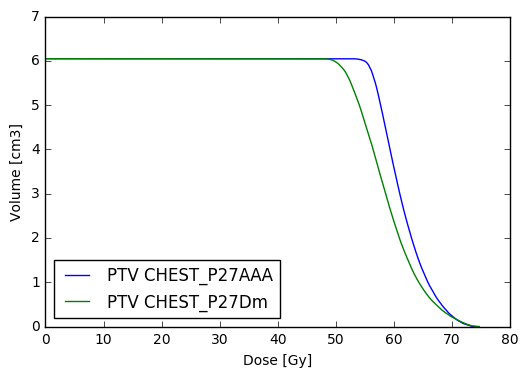

In [20]:
compare_dvh(key=5)

Structure:      ITV_P19AAA         ITV_P19Dm          Rel Diff       Abs diff
-----
DVH Type:  cumulative, abs dose: Gy, abs volume: cm3
Volume:             0.96 cm3          0.96 cm3         +0.00 %          +0.00
Max:               74.04 Gy          74.63 Gy          +0.80 %          +0.59
Min:               64.15 Gy          58.71 Gy          -8.48 %          -5.44
Mean:              68.51 Gy          67.42 Gy          -1.58 %          -1.08
D100:               0.00 Gy           0.00 Gy          +0.00 %          +0.00
D98:               65.22 Gy          61.30 Gy          -6.01 %          -3.92
D95:               65.59 Gy          62.32 Gy          -4.99 %          -3.27
D2cc:               0.00 Gy           0.00 Gy          +0.00 %          +0.00


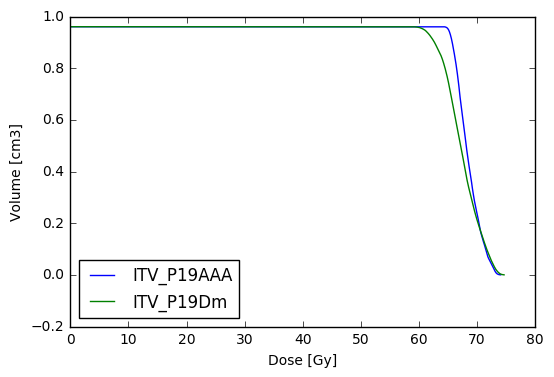

In [21]:
compare_dvh(key=3)

AAA/AXB grid sizes are different. Functions below put them on same grid